# GNN Turbulence Model
## Load in dataset
### Dataset is in cartesian, convert to staggered points in 

In [1]:
import sys
import numpy as np
import torch
from tqdm.notebook import tqdm


# %matplotlib ipympl
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
from cmap import Colormap
from matplotlib import pyplot as plt
### standard parameters
plt.rcParams['figure.figsize'] = (6, 2)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['animation.embed_limit'] = 2**128
icefire_mpl = Colormap('icefire').to_matplotlib()
try:
    plt.colormaps.register(icefire_mpl, name='icefire')
except:
    pass
plt.rcParams["image.cmap"] = 'icefire'

import matplotlib.animation as animation
from IPython.display import HTML

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.spatial import Voronoi, Delaunay

from models.models import *
from models.tmp_models import *
from src.mesh_util import *
from src.data_util import *

In [2]:
# load data

# filenames = {'baseline_64': 'kolmogorov_re_1000/eval_2048x2048_64x64.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000/long_eval_2048x2048_64x64.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000/eval_64x64_64x64.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000_fig1/baseline_64x64.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000_fig1/baseline_256x256.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000_fig1/baseline_2048x2048.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_4000/eval_128x128_128x128.nc'}
# filenames = {'baseline_64': 'decaying/eval_1024x1024_64x64.nc'}
filenames = {'baseline_64': 'decaying/eval_2048x2048_64x64.nc'}

data = load_dataset(filenames,path='data/')
data = data['baseline_64']
dt = data.stable_time_step
dt = (data.time[1]-data.time[0]).data

x_range = (data.x.min().item(),data.x.max().item())
y_range = (data.y.min().item(),data.y.max().item())

x_range = (0,2*np.pi)
y_range = (0,2*np.pi)

print(x_range,y_range)
print(dt)


(0, 6.283185307179586) (0, 6.283185307179586)
0.07012483601762931


## Mesh Creation


In [3]:

# setup mesh

rows = 64
cols = 64

# rows = 32
# cols = 32

# rows = 16
# cols = 16


staggered_points = np.empty((rows,cols,2))

dx = (x_range[1]-x_range[0])/(rows)
dy = (y_range[1]-y_range[0])/(cols)
staggered_points[:,:,1] = np.arange(y_range[0],y_range[1]-dy/10,dy)[:,np.newaxis]
for i in range(rows):
    point_row = np.arange(x_range[0],x_range[1]-6*dx/10,dx)
    staggered_points[i,:,0] = point_row + i%2*(dx/2) # stagger
    # staggered_points[i,:,0] = point_row 

staggered_points = staggered_points.reshape(-1,2)

original_spacing = (data.x.max().values - data.x.min().values)/64
mesh, connectivity, connectivity_periodic, edge_attr, edge_attr_periodic = delanay_mesh_constructor(staggered_points,periodic=True,bidirectional=True,periodic_limits=np.array([[x_range[0],x_range[1]],[y_range[0],y_range[1]]]))
# mesh, connectivity, connectivity_periodic, edge_attr, edge_attr_periodic = cartesian_mesh_contructor(staggered_points,periodic=True,bidirectional=True,periodic_limits=np.array([[x_range[0],x_range[1]],[y_range[0],y_range[1]]]))

# combine connectivities
connectivity_combined = np.concatenate([connectivity,connectivity_periodic],axis=1)

# combine relative position
edge_attr_combined = np.concat([edge_attr,edge_attr_periodic],axis=0)


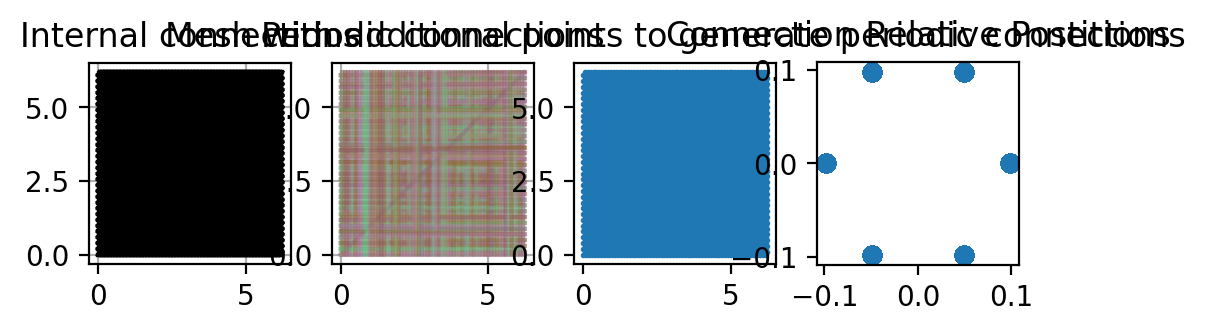

In [4]:
# fig = plt.figure(figsize=(16,6),dpi=300)
fig = plt.figure()
ax = fig.add_subplot(141)
ax.plot(staggered_points[connectivity,0],staggered_points[connectivity,1],c='k')
ax.set_aspect('equal')
ax.set_title('Internal connections')
ax.grid(True)
ax = fig.add_subplot(142)
ax.plot(staggered_points[connectivity_periodic,0],staggered_points[connectivity_periodic,1],alpha=0.2)
ax.set_title('Periodic connections')
ax.set_aspect('equal')
ax.grid(True)

# fig = plt.figure(figsize=(6,6),dpi=300)
ax = fig.add_subplot(143)
ax.scatter(staggered_points[:,0],staggered_points[:,1],s=1)
ax.set_title('Mesh with additional points to generate periodic connections')
ax.set_aspect('equal')
# plt.show()

# fig = plt.figure(figsize=(16,5),dpi=300)
ax = fig.add_subplot(144)
ax.scatter(edge_attr_combined[:,0],edge_attr_combined[:,1])
ax.set_aspect('equal')
ax.set_title('Connection Relative Postitions')
plt.show()

## Interpolation of values
### Original data is in cartesian system. Convert to polygon points from previously generated mesh

In [5]:
from scipy.interpolate import RegularGridInterpolator

rho = 1.0


# plot figures
timestep = 0
sample_ind = 0

sample_inds = data.sample
time_arr = data.time


# periodicity of domain
x = np.empty(len(data.x)+2)
y = np.empty(len(data.y)+2)
x[1:-1] = data.x
y[1:-1] = data.y

x[0] = data.x[0] - (data.x[1]-data.x[0])
x[-1] = data.x[-1] + (data.x[-1]-data.x[-2])
y[0] = data.y[0] - (data.y[1]-data.y[0])
y[-1] = data.y[-1] + (data.y[-1]-data.y[-2])

u = np.empty((*data.u.shape[:2],data.u.shape[2]+2,data.u.shape[3]+2))
v = np.empty((*data.u.shape[:2],data.v.shape[2]+2,data.v.shape[3]+2))
u[:,:,1:-1,1:-1] = data.u
v[:,:,1:-1,1:-1] = data.v
u[:,:,0] = u[:,:,-2]
v[:,:,0] = v[:,:,-2]
u[:,:,-1] = u[:,:,1]
v[:,:,-1] = v[:,:,1]
u[:,:,:,0] = u[:,:,:,-2]
v[:,:,:,0] = v[:,:,:,-2]
u[:,:,:,-1] = u[:,:,:,1]
v[:,:,:,-1] = v[:,:,:,1]

# velocity data saved on staggered grid. Linear interpolation to node center
u = 0.5*(np.roll(u,shift=1,axis=-2)+u)
v = 0.5*(np.roll(v,shift=1,axis=-2)+v)

interp_u = RegularGridInterpolator([data.sample,data.time,x,y],u,bounds_error=False)
interp_v = RegularGridInterpolator([data.sample,data.time,x,y],v,bounds_error=False)

# reshape with samples and time steps
# extend last dimension by 2 to include sample and time info
staggered_points_full_set = np.tile(staggered_points,[len(data.sample),len(data.time),1,2])
staggered_points_full_set[:,:,:,0] = data.sample.to_numpy()[:,np.newaxis,np.newaxis]
staggered_points_full_set[:,:,:,1] = data.time.to_numpy()[np.newaxis,:,np.newaxis]
flattened = staggered_points_full_set.reshape(-1,4) # [[sample, time, x, y], ...]

staggered_points_u = interp_u(flattened) # [u, ...]
staggered_points_v = interp_v(flattened)

staggered_points_full_set_vel = np.stack([staggered_points_u.reshape(len(data.sample),len(data.time),rows,cols),staggered_points_v.reshape(len(data.sample),len(data.time),rows,cols)],axis=4)


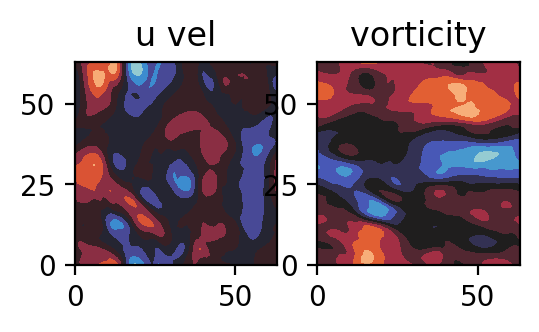

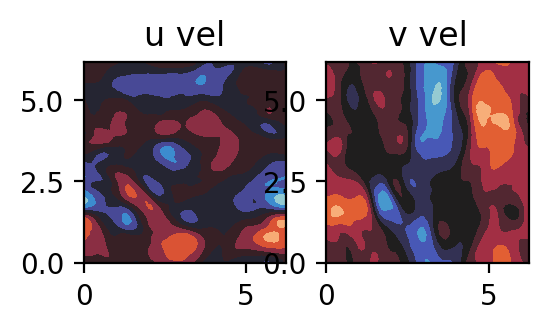

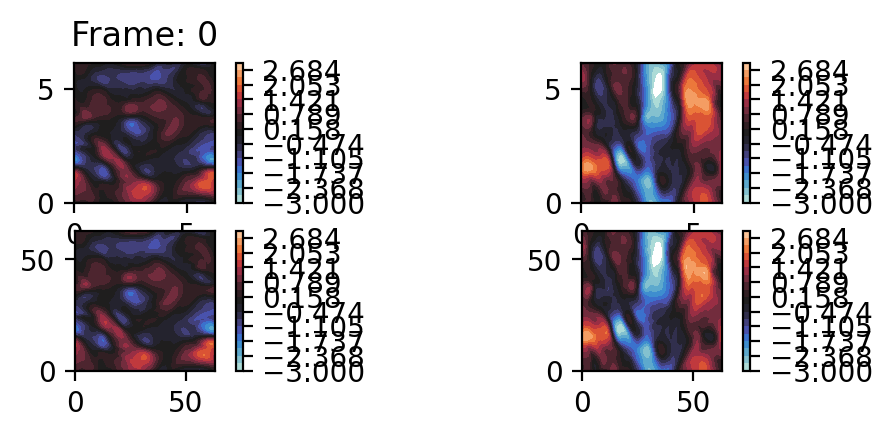

In [6]:

# fig = plt.figure(figsize=(4,2),dpi=300)
fig = plt.figure()
ax = fig.add_subplot(141)
ax.contourf(data.u[sample_ind,timestep])
ax.set_aspect('equal')
ax.set_title('u vel')
ax = fig.add_subplot(142)
ax.contourf(data.v[sample_ind,timestep])
ax.set_aspect('equal')
ax.set_title('v vel')
# ax = fig.add_subplot(143)
# ax.contourf(data.pressure[sample_ind,timestep])
# ax.set_aspect('equal')
# ax.set_title('pressure')
# ax = fig.add_subplot(144)
# ax.contourf(data.vorticity[sample_ind,timestep])
ax.set_aspect('equal')
ax.set_title('vorticity')


plt.show()

# fig = plt.figure(figsize=(1,2),dpi=300)
fig = plt.figure()
ax = fig.add_subplot(141)
ax.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),staggered_points_full_set[0,0,:,3].flatten(),staggered_points_full_set_vel[0,0,:,:,0].flatten())
ax.set_aspect('equal')
ax.set_title('u vel')
ax = fig.add_subplot(142)
ax.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),staggered_points_full_set[0,0,:,3].flatten(),staggered_points_full_set_vel[0,0,:,:,1].flatten())
ax.set_aspect('equal')
ax.set_title('v vel')
# ax = fig.add_subplot(143)
# ax = fig.add_subplot(144)
plt.show()

# animate interpolated value evolution



# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import matplotlib.tri as tri
# import numpy as np

# 1. Initial plot
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

levels = np.linspace(-3, 3, 20)
tcf1 = ax1.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),
                        staggered_points_full_set[0,0,:,3].flatten(),
                        staggered_points_full_set_vel[0,0,:,:,0].flatten(), levels=levels)
tcf2 = ax2.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),
                        staggered_points_full_set[0,0,:,3].flatten(),
                        staggered_points_full_set_vel[0,0,:,:,1].flatten(), levels=levels)
tcf3 = ax3.contourf(data.u[sample_ind,0].T, levels=levels)
tcf4 = ax4.contourf(data.v[sample_ind,0].T, levels=levels)

ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')

fig.colorbar(tcf1)
fig.colorbar(tcf2)
fig.colorbar(tcf3)
fig.colorbar(tcf4)

def animate(i):
    global tcf1,tcf2,tcf3,tcf4
    # Directly call remove on the TriContourSet object
    if tcf1:
        tcf1.remove()
    if tcf2:
        tcf2.remove()   
    if tcf3:
        tcf3.remove()
    if tcf4:
        tcf4.remove()
    # Draw the new tricontourf
    tcf1 = ax1.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),
                         staggered_points_full_set[0,0,:,3].flatten(),
                         staggered_points_full_set_vel[0,i,:,:,0].flatten(), levels=levels)
    tcf2 = ax2.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),
                            staggered_points_full_set[0,0,:,3].flatten(),
                            staggered_points_full_set_vel[0,i,:,:,1].flatten(), levels=levels)
    tcf3 = ax3.contourf(data.u[sample_ind,i].T, levels=levels)
    tcf4 = ax4.contourf(data.v[sample_ind,i].T, levels=levels)
    
    ax1.set_title(f'Frame: {i}')
    
    # Since ContourSet is now a single artist, return it directly for blitting
    return (tcf1,tcf2,tcf3,tcf4)

# 3. Create the animation (blit=True is now supported)
anim = animation.FuncAnimation(fig, animate, frames=staggered_points_full_set_vel.shape[1]-1, 
                               interval=40, blit=True)

plt.show()
# HTML(anim.to_jshtml())


## Training Setup

In [7]:
ind_skip = 1
unroll_inds = 10
unroll_inds = 0
device = 'cuda'

dt_skip = ind_skip*dt
skip = staggered_points_full_set_vel[:,::ind_skip]
train_test_split = 0.8

train_data = skip[:int(skip.shape[0]*train_test_split)]
test_data = skip[int(skip.shape[0]*train_test_split):]

# torch.randperm()


# set device
e = torch.tensor(edge_attr_combined,dtype=torch.float32).to(device)
train_input = torch.tensor(train_data[:,:-1-unroll_inds],dtype=torch.float32).to(device)
train_target = torch.tensor(train_data[:,1:train_data.shape[1]-unroll_inds],dtype=torch.float32).to(device)
if unroll_inds > 0:
    train_unrolled_target = torch.tensor(train_data[:,1+unroll_inds:],dtype=torch.float32).to(device)
train_target = (train_target - train_input)/dt_skip
print(train_input.mean())
print(train_input.std())
print(train_target.mean())
print(train_target.std())

test_input = torch.tensor(test_data[:,:-1-unroll_inds],dtype=torch.float32).to(device)
test_target = torch.tensor(test_data[:,1:test_data.shape[1]-unroll_inds],dtype=torch.float32).to(device)
if unroll_inds > 0:
    test_unrolled_target = torch.tensor(test_data[:,1+unroll_inds:],dtype=torch.float32).to(device)
test_target = (test_target - test_input)/dt_skip
# tmp = test_target.detach().clone()
# tmp = tmp.reshape(tmp.shape[0],tmp.shape[1],rows*cols,2)

ij = torch.tensor(connectivity_combined,dtype=torch.long).to(device)

tmp = test_target.reshape(*test_target.shape[0:2],rows*cols,2)
tmp_input = test_input.reshape(*test_target.shape[0:2],rows*cols,2)
train_input = train_input.reshape(-1,rows*cols,2)
test_input = test_input.reshape(-1,rows*cols,2)
train_target = train_target.reshape(-1,rows*cols,2)
test_target = test_target.reshape(-1,rows*cols,2)

if unroll_inds > 0:
    train_unrolled_target = train_unrolled_target.reshape(-1,rows*cols,2)
    test_unrolled_target = test_unrolled_target.reshape(-1,rows*cols,2)

print(train_input.shape)
print(test_input.shape)
print(train_target.shape)
print(test_target.shape)
print(ij.shape)
print(e.shape)




# testing

# # test stability
# inds = 0
# unroll = 20
# test_unroll_data = torch.Tensor(test_data[inds,:-1]).to(device)
# test_unroll_target = torch.Tensor(test_data[inds,1:]).to(device)

# # test_unroll_data = (test_unroll_data - node_mean)/node_std
# # test_unroll_target = (test_unroll_target - node_mean)/node_std

# test_unroll_data = test_unroll_data.reshape(-1,rows*cols,2)
# test_unroll_target = test_unroll_target.reshape(-1,rows*cols,2)

# velocity = test_unroll_data[0].unsqueeze(0)
# model_unroll = torch.empty_like(test_unroll_data).to(device)
# # tmp_unroll = torch.empty_like(test_unroll_data).to(device)

# test_unroll_target_dudt = test_target.reshape(test_data.shape[0],test_data.shape[1]-1,rows*cols,2)
# test_unroll_target_dudt = torch.cumsum(test_unroll_target_dudt,1)*dt_skip + test_input.reshape(test_data.shape[0],test_data.shape[1]-1,rows*cols,2)[:,0:1,:,:]
# test_unroll_target_dudt = test_unroll_target_dudt[inds]

tensor(-3.2201e-05, device='cuda:0')
tensor(0.9803, device='cuda:0')
tensor(-1.4603e-06, device='cuda:0')
tensor(0.6561, device='cuda:0')
torch.Size([7308, 4096, 2])
torch.Size([2436, 4096, 2])
torch.Size([7308, 4096, 2])
torch.Size([2436, 4096, 2])
torch.Size([2, 24576])
torch.Size([24576, 2])


In [8]:
# normalize inputs
e_mean,e_std = e.mean(), e.std()
node_mean,node_std = train_input.mean(), train_input.std()
output_mean,output_std = train_target.mean(), train_target.std()

train_input = (train_input - node_mean)/node_std
train_target = (train_target - output_mean)/output_std
test_input = (test_input - node_mean)/node_std
test_target = (test_target - output_mean)/output_std

e = (e - e_mean)/e_std
# print(e[:4])

# # test stability
# inds = 0
# unroll = 20
# test_unroll_data = torch.Tensor(test_data[inds,:-1]).to(device)
# test_unroll_target = torch.Tensor(test_data[inds,1:]).to(device)

# test_unroll_data = (test_unroll_data - node_mean)/node_std
# # test_unroll_target = (test_unroll_target - output_mean)/output_std
# test_unroll_target = (test_unroll_target - node_mean)/node_std

# test_unroll_data = test_unroll_data.reshape(-1,rows*cols,2)
# test_unroll_target = test_unroll_target.reshape(-1,rows*cols,2)

# velocity = test_unroll_data[0].unsqueeze(0)
# model_unroll = torch.empty_like(test_unroll_data).to(device)
# # tmp_unroll = torch.empty_like(test_unroll_data).to(device)

# test_unroll_target_dudt = test_target.reshape(test_data.shape[0],test_data.shape[1]-1,rows*cols,2)
# test_unroll_target_dudt1 = test_unroll_target_dudt.detach().clone()
# test_unroll_target_dudt1 = (output_std*torch.cumsum(test_unroll_target_dudt1,1)
#                            + output_mean*torch.arange(test_unroll_target_dudt1.shape[1])[torch.newaxis,:,torch.newaxis,torch.newaxis].to(device))*dt_skip/node_std
# test_unroll_target_dudt1 += test_input.reshape(test_data.shape[0],test_data.shape[1]-1,rows*cols,2)[:,0:1,:,:]

# # # denormalize
# # test_unroll_target_dudt = (test_unroll_target_dudt + output_mean)*output_std
# # test_unroll_target_dudt = (torch.cumsum(test_unroll_target_dudt,1)*dt_skip)
# # test_unroll_target_dudt += (test_input.reshape(test_data.shape[0],test_data.shape[1]-1,rows*cols,2)[:,0:1,:,:]*node_std + node_mean)
# # test_unroll_target_dudt = (test_unroll_target_dudt - node_mean)/node_std


# test_unroll_target_dudt = test_unroll_target_dudt[inds]

In [9]:
# energy_loss_lambda = 1e-8
# energy_loss_lambda = 0


# train model

# construct model
model = MeshGraphNet(npasses=8,
                     ndim=64,
                     node_fc_depth=3,
                     edge_fc_depth=3,
                     node_input_dim=2,
                     edge_input_dim=2,
                     activation=nn.SiLU(),
                     dropout_rate=0.05).to(device)

class MGNold_args:
    def __init__(self):
        self.passes = 4
        self.n_hidden = 4
        self.dim_hidden = 16
dims = {'z': 2,
        'q': 0,
        'q_0': 2,
        'n': 0,
        'f': 0,
        'g': 0,
        'd': 0}

model_old = MeshGraphNetOld(MGNold_args(),dims).to(device)

opt = torch.optim.Adam(model.parameters(),lr=1e-3)
decay = torch.optim.lr_scheduler.ExponentialLR(opt,0.9999)
# opt_old = torch.optim.Adam(model_old.parameters(),lr=1e-3)
# decay_old = torch.optim.lr_scheduler.ExponentialLR(opt_old,0.9999)
# decay = torch.optim.lr_scheduler.ExponentialLR(opt,1.0)

model.train()
# model_old.train()

loss_hist = []
test_loss_hist = []
lr_hist = []
lr_hist_old = []
loss_hist_old = []
test_loss_hist_old = []

# print(model.node.ff[0])

In [10]:
loss_fn = torch.nn.MSELoss()
# if unroll_inds > 0:
#     def loss_fn(v,v_target,v_unroll,v_unroll_target,energy_loss_lambda=1e-12):
#         # standard mse
#         loss_mse = torch.nn.MSELoss()(v,v_target)
#         # additional energy loss
#         v_energy = (v_unroll**2).sum(-1).mean(-1)
#         v_target_energy = (v_unroll_target**2).sum(-1).mean(-1)
#         loss_energy = torch.nn.MSELoss()(v_energy,v_target_energy)
#         # loss_energy = (v_energy-v_target_energy)**2
#         return loss_mse + energy_loss_lambda*loss_energy

class MSELossWithDivergence(nn.Module):
    def __init__(self,relative_position,ij,num_nodes,divergence_lambda: float = 0.01):
        self.divergence_lambda = divergence_lambda
        self.ij = ij
        self.init_least_square_gradient_calc(relative_position,ij,num_nodes)

        unique_idx, self.counts = torch.unique(self.ij[0], return_counts=True)
        max_conn = self.counts.max().item()
        self.connection_slots = torch.cat([torch.arange(c) for c in self.counts]).to(device)

        self.sort_inds_ij = torch.argsort(self.ij[0])
        self.sorted_node_indices = self.ij[0][self.sort_inds_ij]

    
    def init_least_square_gradient_calc(self,relative_position,ij,num_nodes):
        weighting = 1/((relative_position[self.ij[0]])**2).sum(1)
        unique_indices, counts = torch.unique(self.ij[0], return_counts=True)
        max_rows = counts.max().item()

        # padded tensor for differeing number of connections per node
        E_batched = torch.zeros(num_nodes, max_rows, 2, device=device)
        W_batched = torch.zeros(num_nodes, max_rows, max_rows, device=device)

        for i in range(num_nodes):
            mask = (self.ij[0] == i)
            rows = e[mask]
            E_batched[i, :rows.size(0), :] = rows
            # Weighting is diagonal use vector
            W_diag = weighting[mask]
            W_batched[i, :rows.size(0), :rows.size(0)] = torch.diag(W_diag)

        ET = E_batched.transpose(1, 2)
        WTW = W_batched.transpose(1, 2) @ W_batched 
        G = ET @ WTW @ E_batched

        rhs = ET @ WTW
        self.inv_square_mesh_mat = torch.linalg.solve(G, rhs)
    

    def calc_gradient_batched(self, v):
        B, N, _ = v.shape
        
        diff = v[:, self.ij[0], :] - v[:, self.ij[1], :] 
        
        
        diff = diff[:, self.sort_inds_ij, :] 

        # scatter into padded
        max_conn = self.inv_square_mesh_mat.shape[-1]
        diff_padded = torch.zeros(B, N, max_conn, 2, device=v.device)
        
        # map edges
        # connection_slots and sorted_node_indices are from step 1
        diff_padded[:, self.sorted_node_indices, self.connection_slots, :] = diff

        
        # b: batch, n: node, i: output_dim, j: max_conn, k: feature_dim (2)
        grad = torch.einsum('nij,bnjk->bnik', self.inv_square_mesh_mat, diff_padded)
        
        return grad

    def loss_calc(self, v_predict, v_target):
        loss = torch.nn.MSELoss()(v_predict, v_target)
        
        gradient = self.calc_gradient_batched(v_predict)

        div_per_node = gradient[:, :, 0, 0] + gradient[:, :, 1, 1]
        
        # Mean across nodes, then mean across batch
        divergence_loss = (div_per_node.mean(dim=1)**2).mean()
        
        return loss + self.divergence_lambda * divergence_loss
    
# loss_class = MSELossWithDivergence(e,ij,train_input.shape[1])
# loss_fn = loss_class.loss_calc


# batch_input = train_input[0:3]
# pred = model(batch_input,ij,e)
# if unroll_inds > 0:
#     batch_unroll = train_unrolled_target[0:3]
#     unrolling = pred.detach().clone()
#     for _ in range(unroll_inds):
#         unrolling = model(unrolling,ij,e)
#     loss = loss_fn(pred,train_target[0:3],unrolling,train_unrolled_target[0:3])
# else:
#     loss = loss_fn(pred,train_target[0:3])
# print(loss)

In [ ]:

epochs = 100*6*8
epochs = 500
# batch_size = 84
batch_size = 2
test_interval = 10
unroll_inds = 2

# dui/dxi
def train(epochs,batch_size,model,opt,decay,train_input,train_target,test_input,test_target,ij,e,lr_hist,loss_hist,test_loss_hist):
    pbar = tqdm(range(epochs),position=0,leave=False)
    for i in pbar:
        shuffled_inds = torch.randperm(train_input.shape[0])
        shuffled_input = train_input[shuffled_inds]
        shuffled_target = train_target[shuffled_inds]
        train_loss_track = 0.0
        # train_loss_track_old = 0.0
        if unroll_inds > 0:
            shuffled_unroll_target = train_unrolled_target[shuffled_inds]
        pbar2 = tqdm(range(int(train_input.shape[0]/batch_size)),position=1,leave=False)
        for j in pbar2:
        # for j in tqdm(range(int(train_input.shape[0]/batch_size)),position=1):
            batch_input = shuffled_input[j*batch_size:(j+1)*batch_size]
            batch_target = shuffled_target[j*batch_size:(j+1)*batch_size]
            model.zero_grad()
            # model_old.zero_grad()
            pred = model(batch_input,ij,e)
            # pred_old = model_old(batch_input,ij,e)
            if unroll_inds > 0:
                batch_unroll_target = shuffled_unroll_target[j*batch_size:(j+1)*batch_size]
                pred_unroll = pred.detach().clone()
                for k in range(unroll_inds):
                    pred_unroll = model(pred_unroll,ij,e)
                loss = loss_fn(pred,batch_target,pred_unroll,batch_unroll_target)
            else:
                loss = loss_fn(pred,batch_target)
                # loss_old = loss_fn(pred_old,batch_target)
            
            train_loss_track += loss.item()*batch_input.shape[0]/train_input.shape[0]
            # train_loss_track_old += loss_old.item()*batch_input.shape[0]/train_input.shape[0]
            pbar2.set_postfix({'Train Loss': loss.item()})

            # loss = loss_fn(pred,batch_target)
        
            loss.backward()
            # loss_old.backward()
            opt.step()
            # opt_old.step()
        decay.step()
        # decay_old.step()

        # tqdm.write(f"Step {i}: Loss {loss.item()}")
        loss_hist.append(train_loss_track)
        # loss_hist_old.append(train_loss_track)
        lr_hist.append(opt.param_groups[0]['lr'])

        if i%test_interval == 0:
            with torch.no_grad():
                model.eval()
                rand_sample = torch.randperm(test_input.shape[0])
                test_loss_track = 0.0
                # test_loss_track_old = 0.0
                pbar3 = tqdm(range(int(test_input.shape[0]/batch_size)),position=2,leave=False)
                for j in pbar3:
                # for j in tqdm(range(int(test_input.shape[0]/batch_size)),position=1):
                    batch_input = test_input[rand_sample][j*batch_size:(j+1)*batch_size]
                    batch_target = test_target[rand_sample][j*batch_size:(j+1)*batch_size]
                    pred_test = model(batch_input,ij,e)
                    # pred_test_old = model_old(batch_input,ij,e)
                    if unroll_inds > 0:
                        batch_unroll_target = test_unrolled_target[rand_sample][j*batch_size:(j+1)*batch_size]
                        pred_unroll = pred_test.detach().clone()
                        for k in range(unroll_inds):
                            pred_unroll = model(pred_unroll,ij,e)
                        test_loss = loss_fn(pred_test,batch_target,pred_unroll,batch_unroll_target)
                    else:
                        test_loss = loss_fn(pred_test,batch_target)
                        # test_loss_old = loss_fn(pred_test_old,batch_target)

                    # test_loss = loss_fn(pred_test,batch_target)
                
                    test_loss_track += test_loss.item()*batch_input.shape[0]/test_input.shape[0]
                    # test_loss_track_old += test_loss_old.item()*batch_input.shape[0]/test_input.shape[0]
                    pbar3.set_postfix({'Test Loss': test_loss.item()})


                test_loss_hist.append(test_loss_track)
                # test_loss_hist_old.append(test_loss_track_old)
            model.train()
        pbar.set_postfix({'Step': i, 'Train Loss': train_loss_track, 'Test Loss': test_loss_track,'LR': opt.param_groups[0]['lr']})
        # pbar.set_postfix({'Step': i, 'Train Loss': train_loss_track, 'Train Loss Old': train_loss_track_old, 'Test Loss': test_loss_track, 'Test Loss Old': test_loss_track_old, 'LR': opt.param_groups[0]['lr']})

    # return lr_hist, train_loss_track, test_loss_hist

def train_unroll(epochs,batch_size,model,opt,decay,train_input,train_target,test_input,test_target,ij,e,lr_hist,loss_hist,test_loss_hist):
    train_input = train_input.reshape(train_data.shape[0],train_data.shape[1]-1,rows*cols,2)
    test_input = test_input.reshape(test_data.shape[0],test_data.shape[1]-1,rows*cols,2)
    pbar = tqdm(range(epochs),position=0,leave=False)
    for i in pbar:
        shuffled_inds = torch.randperm(train_input.shape[0])
        shuffled_input = train_input[shuffled_inds]
        # shuffled_target = train_target[shuffled_inds]
        train_loss_track = 0.0
        # if unroll_inds > 0:
        #     shuffled_unroll_target = train_unrolled_target[shuffled_inds]
        pbar2 = tqdm(range(int(train_input.shape[0])),position=1,leave=False)
        for j in pbar2:
            time_inds = torch.arange(0,train_input.shape[1]-unroll_inds,unroll_inds)
            shuffled_inds = torch.randperm(len(time_inds)).reshape(-1,batch_size)
            pbar3 = tqdm(time_inds[shuffled_inds],position=2,leave=False)
            for k in pbar3:
                batch_input = shuffled_input[j,k]
                model.zero_grad()
                loss = torch.tensor(0.0)
                velocity = batch_input
                for l in range(unroll_inds):
                    batch_target = shuffled_input[j,k+l]
                    dudt = model(velocity,ij,e)
                    velocity = velocity + dudt * dt_skip
                    loss += loss_fn(velocity,batch_target)
        
                # loss_track += loss.item()*batch_input.shape[0]/test_input.shape[0]
                pbar3.set_postfix({'Test Loss': loss.item()})
            
                train_loss_track += loss.item()*batch_input.shape[0]/(train_input.shape[0]*train_input.shape[1])
        
                loss.backward()
                opt.step()
        decay.step()

        loss_hist.append(train_loss_track)
        lr_hist.append(opt.param_groups[0]['lr'])

        if i%test_interval == 0:
            with torch.no_grad():
                model.eval()
                rand_sample = torch.randperm(test_input.shape[0])
                shuffled_input = test_input[rand_sample]
                test_loss_track = 0.0
                pbar2 = tqdm(range(int(test_input.shape[0])),position=1,leave=False)
                for j in pbar2:
                    time_inds = torch.arange(0,test_input.shape[1]-unroll_inds,unroll_inds)
                    shuffled_inds = torch.randperm(len(time_inds)).reshape(-1,batch_size)
                    pbar3 = tqdm(time_inds[shuffled_inds],position=2,leave=False)
                    for k in pbar3:
                        batch_input = shuffled_input[j,k]
                        loss = 0
                        velocity = batch_input
                        for l in range(unroll_inds):
                            batch_target = shuffled_input[j,k+l]
                            dudt = model(velocity,ij,e)
                            velocity = velocity + dudt * dt_skip
                            loss += loss_fn(velocity,batch_target)
                
                        pbar3.set_postfix({'Test Loss': loss.item()})
                        test_loss_track += loss.item()*batch_input.shape[0]/(train_input.shape[0]*train_input.shape[1])
                

                # pbar3 = tqdm(range(int(test_input.shape[0]/batch_size)),position=2,leave=False)
                # for j in pbar3:
                #     batch_input = test_input[rand_sample][j*batch_size:(j+1)*batch_size]
                #     batch_target = test_target[rand_sample][j*batch_size:(j+1)*batch_size]

                #     test_loss = 0
                #     velocity = batch_input
                #     for k in range(unroll_inds):
                #         dudt = model(velocity,ij,e)
                #         velocity = velocity + dudt * dt_skip
                #         test_loss += loss_fn(velocity,batch_target)
                
                #     test_loss_track += test_loss.item()*batch_input.shape[0]/test_input.shape[0]
                #     pbar3.set_postfix({'Test Loss': test_loss.item()})

                test_loss_hist.append(test_loss_track)
            model.train()
        pbar.set_postfix({'Step': i, 'Train Loss': train_loss_track, 'Test Loss': test_loss_track,'LR': opt.param_groups[0]['lr']})

# import copy
# tmp = copy.deepcopy(model)
# model_t, lr_hist, train_loss_track, test_loss_hist = train(2,batch_size,model,opt,decay,train_input,train_target,test_input,test_target,ij,e)
# train(epochs,batch_size,model,opt,decay,train_input,train_target,test_input,test_target,ij,e,lr_hist,loss_hist,test_loss_hist)
train_unroll(epochs,batch_size,model,opt,decay,train_input,train_target,test_input,test_target,ij,e,lr_hist,loss_hist,test_loss_hist)



# # plot loss
# plt.figure()
# plt.semilogy(loss)
# plt.xlabel('Training Step')
# plt.ylabel('MSE Loss')
# plt.title('Training Loss Curve')
# plt.grid()


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

In [ ]:
# torch.save(model.state_dict(), 'new_dudt_formulation.pt')
# import pickle
# # with open('model_old_train_metrics.pkl','wb') as f:
# #     pickle.dump((lr_hist_old,loss_hist_old,test_loss_hist_old),f)
# with open('model_orig_train_metrics.pkl','rb') as f:
#     lr_hist_orig,loss_hist_orig,test_loss_hist_orig = pickle.load(f)
# with open('model_old_train_metrics.pkl','rb') as f:
#     lr_hist_old,loss_hist_old,test_loss_hist_old = pickle.load(f)

# with open('model_orig_norm_train_metrics.pkl','rb') as f:
#     lr_hist_norm,loss_hist_norm,test_loss_hist_norm = pickle.load(f)
#
# with open('model_orig_norm_train_metrics.pkl','wb') as f:
#     pickle.dump((lr_hist,loss_hist,test_loss_hist),f)


# print(tuple_load)
# print((tmp.node.ff[0].layer[0].weight == model.node.ff[0].layer[0].weight).all())

# model.load_state_dict(torch.load('new_dudt_formulation.pt',weights_only=True))
# model.eval()
# model.node.ff[0].layer

# print(lr_hist)
# from torchinfo import summary
# summary(model)


<All keys matched successfully>

In [ ]:
# batch_size = 32
with torch.no_grad():
    model.eval()
    rand_sample = torch.randperm(test_input.shape[0])
    # rand_sample = torch.arange(test_input.shape[0])
    test_loss_track = 0.0
    # test_loss_track_old = 0.0
    pbar3 = tqdm(range(int(test_input.shape[0]/batch_size)),position=2,leave=False)
    for j in pbar3:
    # for j in tqdm(range(int(test_input.shape[0]/batch_size)),position=1):
        batch_input = test_input[rand_sample][j*batch_size:(j+1)*batch_size]
        batch_target = test_target[rand_sample][j*batch_size:(j+1)*batch_size]
        pred_test = model(batch_input,ij,e)
        # pred_test_old = model_old(batch_input,ij,e)
        if unroll_inds > 0:
            batch_unroll_target = test_unrolled_target[rand_sample][j*batch_size:(j+1)*batch_size]
            pred_unroll = pred_test.detach().clone()
            for k in range(unroll_inds):
                pred_unroll = model(pred_unroll,ij,e)
            test_loss = loss_fn(pred_test,batch_target,pred_unroll,batch_unroll_target)
        else:
            test_loss = loss_fn(pred_test,batch_target)
            # test_loss_old = loss_fn(pred_test_old,batch_target)

        # test_loss = loss_fn(pred_test,batch_target)
    
        test_loss_track += test_loss.item()*batch_input.shape[0]/test_input.shape[0]
print(test_loss_track)

  0%|          | 0/609 [00:00<?, ?it/s]

2.2565026758926856


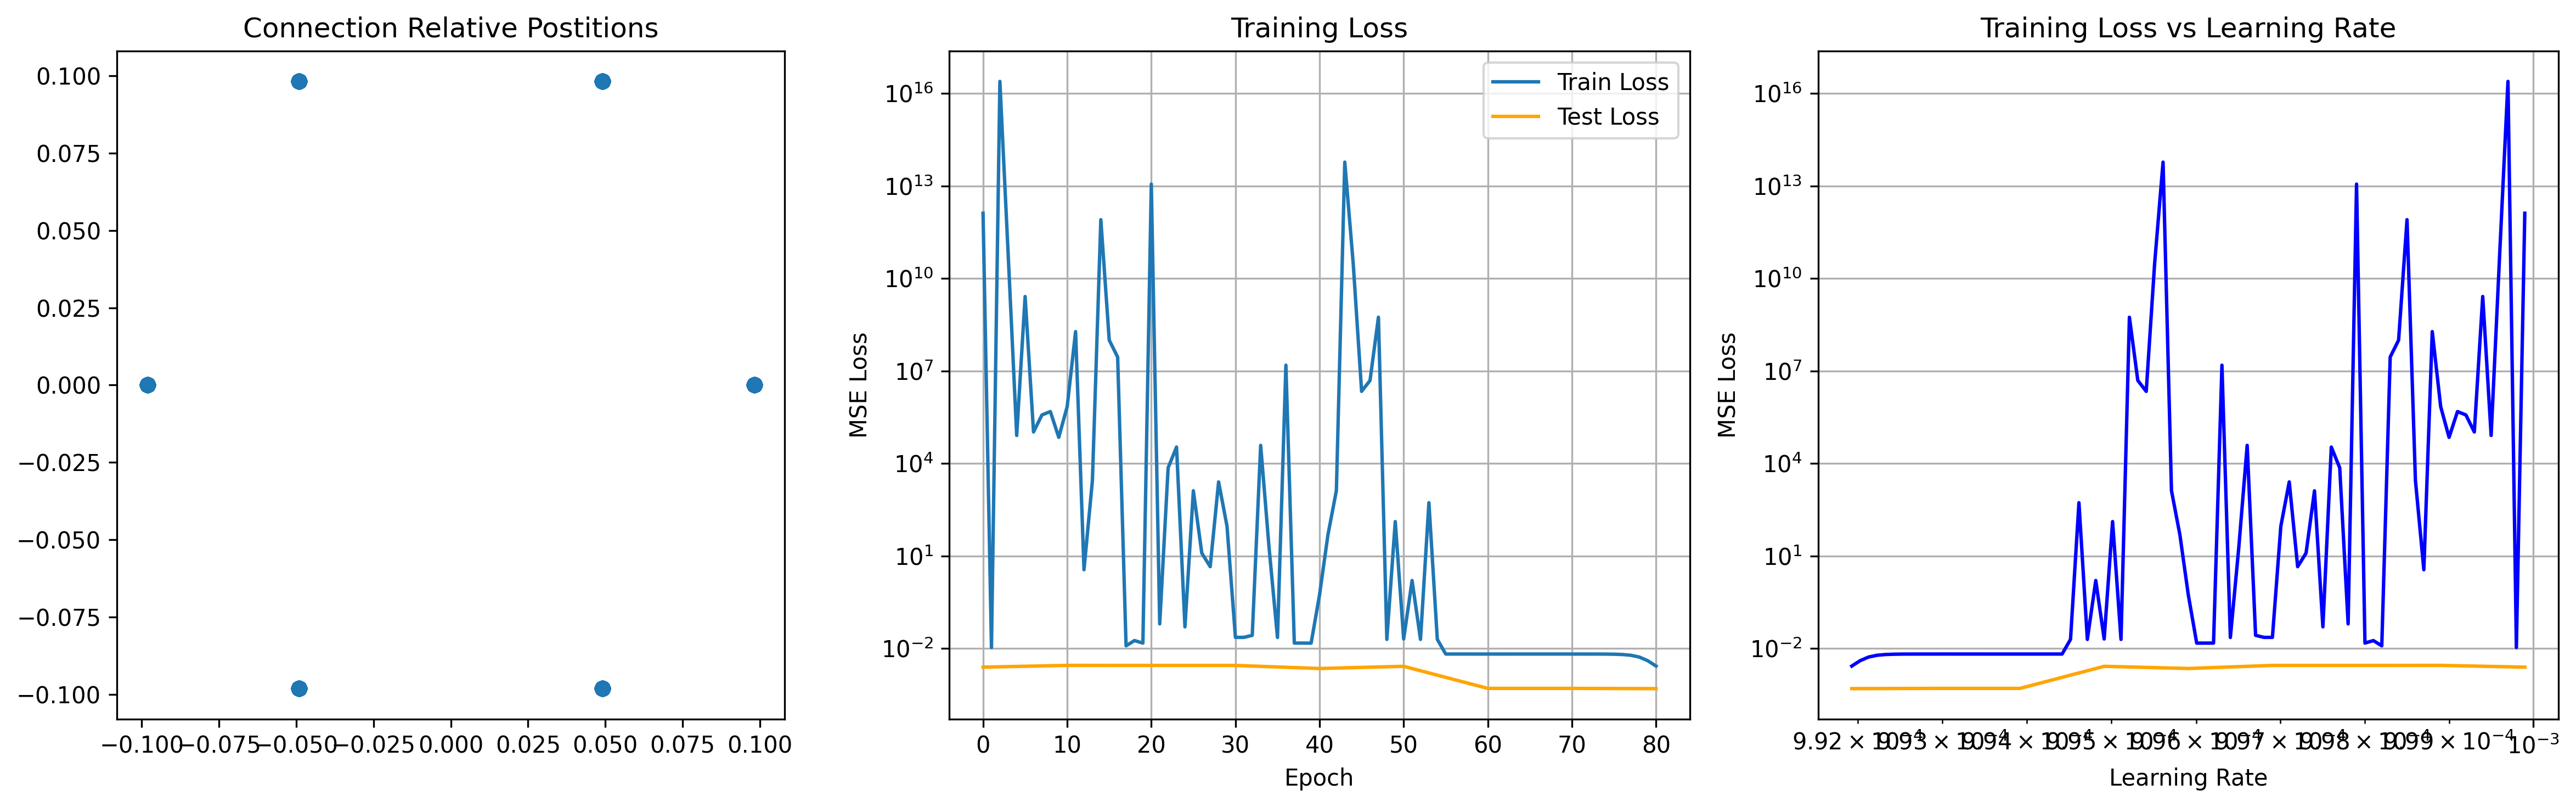

In [18]:

fig = plt.figure(figsize=(16,5),dpi=300)
ax = fig.add_subplot(131)
ax.scatter(edge_attr_combined[:,0],edge_attr_combined[:,1])
ax.set_aspect('equal')
ax.set_title('Connection Relative Postitions')

# fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(132)
ax.plot(loss_hist,label='Train Loss')
# ax.plot(loss_hist_old,label='Train Loss Old')
# ax.plot(loss_hist_orig,label='Train Loss Original')
# ax.plot(loss_hist_old,label='Train Loss Old')
# ax.plot(loss_hist_norm,label='Train Loss Norm')
ax.plot(range(0,len(test_loss_hist)*test_interval,test_interval),test_loss_hist,label='Test Loss',c='orange')
# ax.plot(range(0,len(test_loss_hist)*test_interval//2,test_interval),test_loss_hist_orig,label='Test Loss Original')
# ax.plot(range(0,len(test_loss_hist)*test_interval//2,test_interval),test_loss_hist_old,label='Test Loss Old')
# ax.plot(range(0,len(test_loss_hist)*test_interval//2,test_interval),test_loss_hist_norm,label='Test Loss Norm')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Loss')
# ax.set_ylim([0.1,1])
ax.grid(True)

ax = fig.add_subplot(133)
ax.plot(lr_hist,loss_hist, label='Train Loss', c='blue')
ax.plot(lr_hist[::test_interval],test_loss_hist,label='Test Loss', c='orange')
# ax.plot(lr_hist[::test_interval],test_loss_hist_old,label='Test Loss', c='orange')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Loss vs Learning Rate')
ax.grid(True)

fig.tight_layout()
plt.show()

## Testing

In [22]:
# device = 'cpu'
# test_data = test_data.to(device)
# model = model.to(device)
# ij = ij.to(device)
# e = e.to(device)
# print(train_input.shape)
# print(test_input.shape)
# print(train_target.shape)
# print(test_target.shape)
# print(ij.shape)
# print(e.shape)

# test stability
inds = 1
unroll = 20
test_unroll_data = torch.Tensor(test_data[inds,:-1]).to(device)
test_unroll_target = torch.Tensor(test_data[inds,1:]).to(device)

# # test_unroll_data = (test_unroll_data - node_mean)/node_std
test_unroll_target = (test_unroll_target - test_unroll_data)/dt_skip
# test_unroll_target = (test_unroll_target - output_mean)/output_std
# test_unroll_data = (test_unroll_data - node_mean)/node_std

test_unroll_data = test_unroll_data.reshape(-1,rows*cols,2)
test_unroll_target = test_unroll_target.reshape(-1,rows*cols,2)

model_unroll = torch.empty_like(test_unroll_data).to(device)
# tmp_unroll = torch.empty_like(test_unroll_data).to(device)

test_unroll_target = test_target.reshape(test_data.shape[0],test_data.shape[1]-1,rows*cols,2)
tmp = test_unroll_target.detach().clone()
test_unroll_target = (output_std*torch.cumsum(test_unroll_target,1)
                           + output_mean*torch.arange(test_unroll_target.shape[1])[torch.newaxis,:,torch.newaxis,torch.newaxis].to(device))*dt_skip/node_std
test_unroll_target += test_input.reshape(test_data.shape[0],test_data.shape[1]-1,rows*cols,2)[:,0:1,:,:]

test_unroll_target = test_unroll_target[inds]
velocity = test_unroll_data[0].unsqueeze(0)

# tmp_unroll[0] = test_unroll_data[0] + tmp[inds,0]*dt_skip

# model.eval()
model_old.eval()
with torch.no_grad():
    # print(test_unroll_data.shape)
    # print(model_unroll.shape)
    for i in range(test_unroll_data.shape[0]):
        # velocity = model(velocity,ij,e)

        dudt = model(velocity,ij,e)

        dudt = tmp[inds,i:i+1]

        velocity = dudt*dt_skip + velocity

        # velocity = (output_std*dudt + output_mean)*dt_skip/node_std + velocity
        model_unroll[i] = velocity[0]

        # if i > 0:
        #     tmp_unroll[i] = tmp_unroll[i-1] + tmp[inds,i]*dt_skip 


# tmp_unroll = torch.cumsum(tmp[0],dim=0)*dt_skip + test_unroll_data[0]


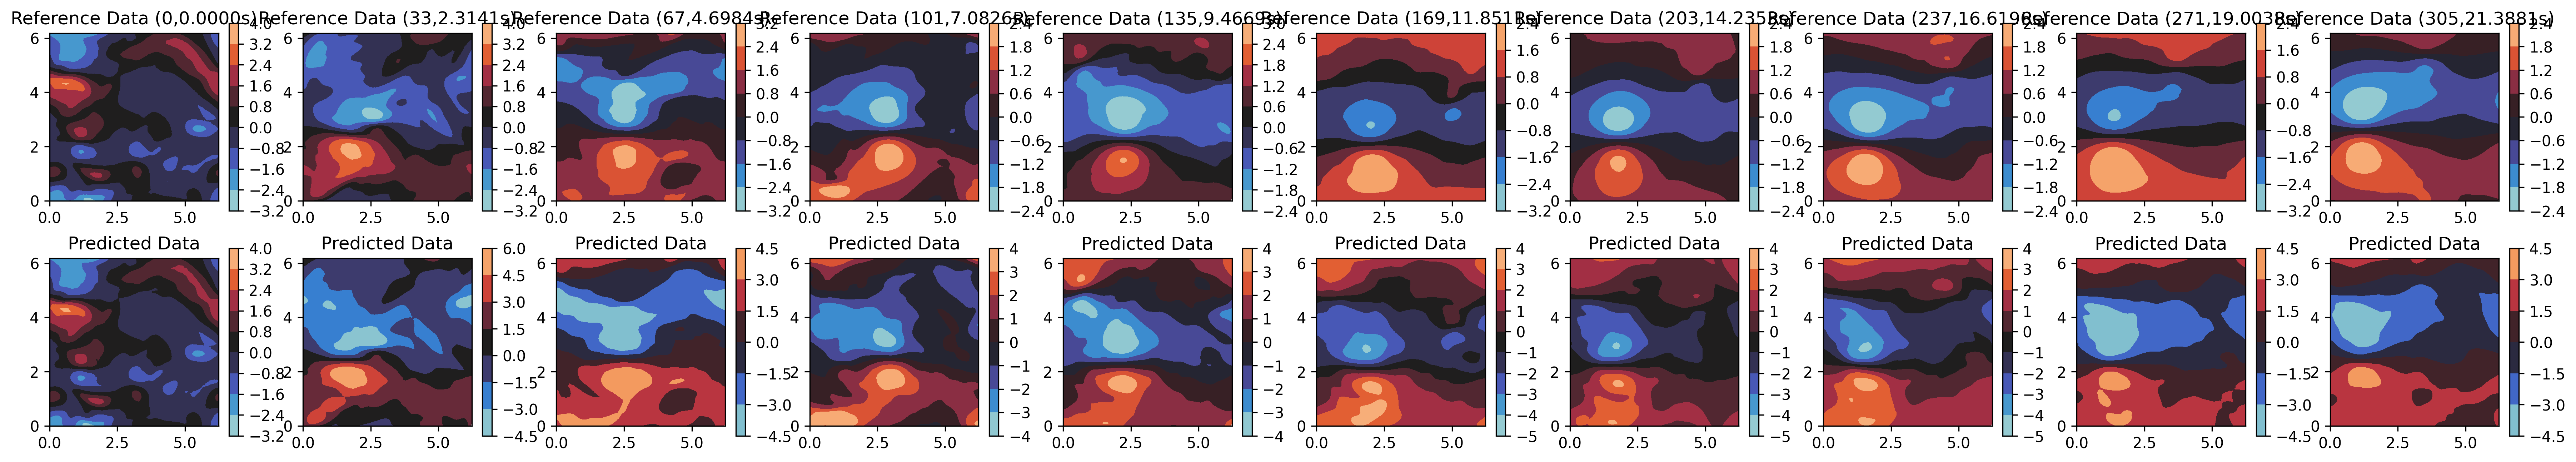

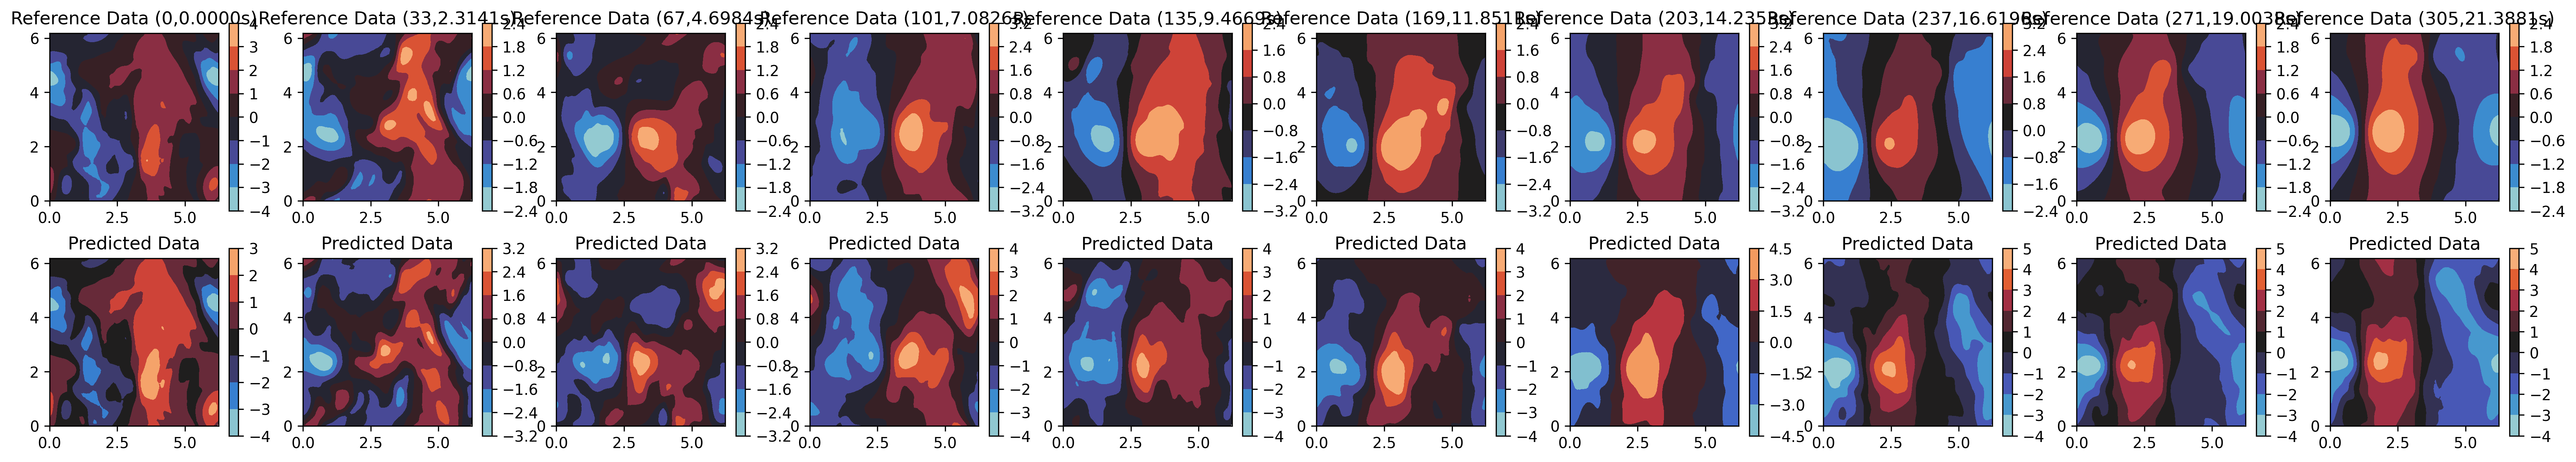

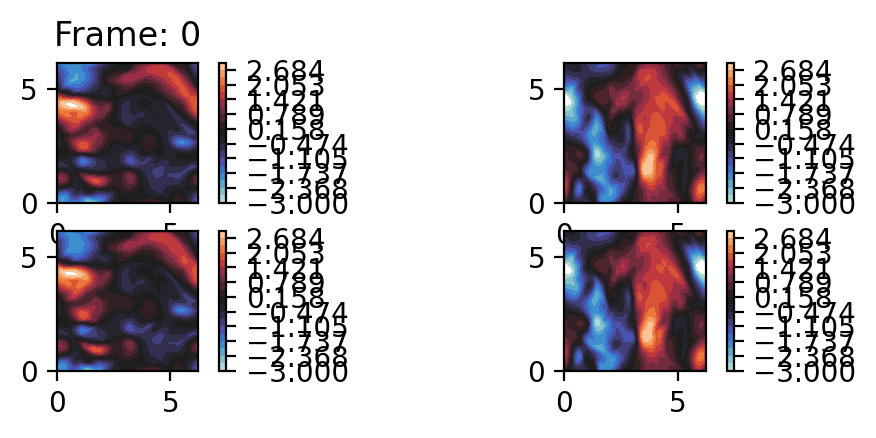

KeyboardInterrupt: 

In [23]:

# compare
model_unroll = model_unroll.cpu().numpy()
model_unroll = np.nan_to_num(model_unroll)
# tmp_unroll = tmp_unroll.cpu().numpy()
test_unroll_target = test_unroll_target.cpu().numpy()
nplots = 10
# time_inds = (np.linspace(0,test_data.shape[1]-2,nplots).astype(int))
time_inds = (np.linspace(0,test_data.shape[1]//2,nplots).astype(int))
# time_inds = (np.linspace(0,9,nplots).astype(int))



# test_unroll_target_dudt = test_target.reshape(test_data.shape[0],test_data.shape[1]-1,rows*cols,2)


# print(staggered_points_full_set_vel.shape)
# print(test_unroll_target.shape)
# print(model_unroll.shape)
# print(tmp_unroll)
# print(tmp.shape)


fig = plt.figure(figsize=(3*nplots,5),dpi=300)
for i,time_ind in enumerate(time_inds):
    # i = int(i)
    ax = fig.add_subplot(2,nplots,i+1)
    # px = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],test_unroll_target[time_ind,:,0])
    px = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],test_unroll_target[time_ind,:,0])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],test_data[inds,i,:,0])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],train_data[inds,i,:,0])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],staggered_points_full_set_vel[inds,i*10,:,:,0].flatten())

    ax.set_aspect('equal')
    ax.set_title('Reference Data (%i,%2.4fs)'%(time_ind,time_ind*dt_skip))
    fig.colorbar(px)

    ax = fig.add_subplot(2,nplots,i+nplots+1)
    px = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],model_unroll[time_ind,:,0])
    # px = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],tmp_unroll[time_ind,:,0])
    ax.set_aspect('equal')
    ax.set_title('Predicted Data')
    fig.colorbar(px)

fig = plt.figure(figsize=(3*nplots,5),dpi=300)
for i,time_ind in enumerate(time_inds):
    # i = int(i)
    ax = fig.add_subplot(2,nplots,i+1)
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],test_unroll_target[time_ind,:,1])
    px = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],test_unroll_target[time_ind,:,1])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],test_data[inds,i,:,0])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],train_data[inds,i,:,0])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],staggered_points_full_set_vel[inds,i*10,:,:,0].flatten())
    fig.colorbar(px)

    ax.set_aspect('equal')
    ax.set_title('Reference Data (%i,%2.4fs)'%(time_ind,time_ind*dt_skip))

    ax = fig.add_subplot(2,nplots,i+nplots+1)
    px = ax.tricontourf(staggered_points[:,0],staggered_points[:,1],model_unroll[time_ind,:,1])
    ax.set_aspect('equal')
    ax.set_title('Predicted Data')
    fig.colorbar(px)

plt.show()
# print(test_data[inds,i,:,0])


fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

levels = np.linspace(-3, 3, 20)
tcf1 = ax1.tricontourf(staggered_points[:,0].flatten(),
                        staggered_points[:,1].flatten(),
                        test_unroll_target[0,:,0].flatten(), levels=levels)
tcf2 = ax2.tricontourf(staggered_points[:,0].flatten(),
                        staggered_points[:,1].flatten(),
                        test_unroll_target[0,:,1].flatten(), levels=levels)
tcf3 = ax3.tricontourf(staggered_points[:,0].flatten(),
                        staggered_points[:,1].flatten(),
                        model_unroll[0,:,0].flatten(), levels=levels)
tcf4 = ax4.tricontourf(staggered_points[:,0].flatten(),
                        staggered_points[:,1].flatten(),
                        model_unroll[0,:,1].flatten(), levels=levels)



ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')

fig.colorbar(tcf1)
fig.colorbar(tcf2)
fig.colorbar(tcf3)
fig.colorbar(tcf4)

def animate(i):
    global tcf1,tcf2,tcf3,tcf4
    # Directly call remove on the TriContourSet object
    if tcf1:
        tcf1.remove()
    if tcf2:
        tcf2.remove()   
    if tcf3:
        tcf3.remove()
    if tcf4:
        tcf4.remove()
    # Draw the new tricontourf
    tcf1 = ax1.tricontourf(staggered_points[:,0].flatten(),
                            staggered_points[:,1].flatten(),
                            test_unroll_target[i,:,0].flatten(), levels=levels)
    tcf2 = ax2.tricontourf(staggered_points[:,0].flatten(),
                            staggered_points[:,1].flatten(),
                            test_unroll_target[i,:,1].flatten(), levels=levels)
    tcf3 = ax3.tricontourf(staggered_points[:,0].flatten(),
                            staggered_points[:,1].flatten(),
                            model_unroll[i,:,0].flatten(), levels=levels)
    tcf4 = ax4.tricontourf(staggered_points[:,0].flatten(),
                            staggered_points[:,1].flatten(),
                            model_unroll[i,:,1].flatten(), levels=levels)
    
    ax1.set_title(f'Frame: {i}')
    
    # Since ContourSet is now a single artist, return it directly for blitting
    return (tcf1,tcf2,tcf3,tcf4)

# 3. Create the animation (blit=True is now supported)
anim = animation.FuncAnimation(fig, animate, frames=model_unroll.shape[0]-1, 
                               interval=40, blit=True)

plt.show()
HTML(anim.to_jshtml())


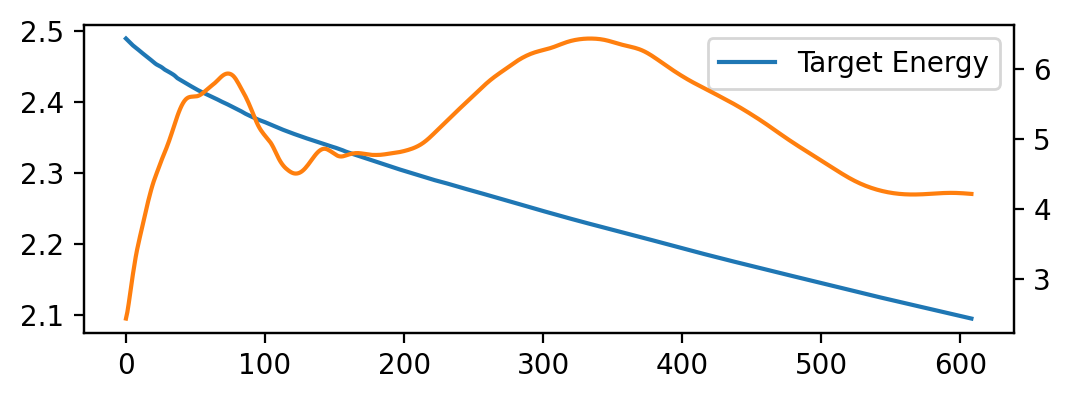

In [21]:
# calculate energy
target_energy = (test_unroll_target ** 2).sum(-1).mean(-1)
model_energy = (model_unroll ** 2).sum(-1).mean(-1)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(target_energy,c='tab:blue',label='Target Energy')
ax2.plot(model_energy,c='tab:orange',label='Predicted Energy')
ax1.legend()
# ax1.set_xlim([0,20])
# ax2.set_xlim([0,20])
# ax1.set_ylim([0,2])
# ax2.set_ylim([0,2])
plt.show()

### Not sure what density is

### Calculate from navier stokes equations (incompressible) with non dimensionalized length and time scales with reynolds number 

$\frac{\partial u_i}{\partial t} = - \frac{d p}{\rho d x_i} - u_j \frac{\partial u_i}{\partial x_j} + \frac{1}{Re} \frac{\partial^2 u_j}{\partial x_i \partial x_j}$


$\frac{du_i}{dx_i} = 0$

### Filtered Navier stokes

In [ ]:
# c
re = 1000
dt = data.stable_time_step

dudx1 = data.u.differentiate('x')
dvdy1 = data.v.differentiate('y')

res = dudx1+dvdy1
print('wtf continutity diff')
print(np.sqrt(res[:,-1]**2).mean().values)

print(data.u[:,0].mean().to_numpy())


u = data.u.to_numpy()
v = data.v.to_numpy()
p = data.pressure.to_numpy()

# u = u[:3,:3,:9,:9]
# v = v[:3,:3,:9,:9]
# p = p[:3,:3,:9,:9]


dx = data.x[1] - data.x[0]
dy = data.y[1] - data.y[0]

dx = dx.values
dy = dy.values

# centered difference derivitive calc
dudx = (np.roll(u,-1,axis=-2) - np.roll(u,1,axis=-2))/dx/2
dudy = (np.roll(u,-1,axis=-1) - np.roll(u,1,axis=-1))/dy/2

dvdx = (np.roll(v,-1,axis=-2) - np.roll(v,1,axis=-2))/dx/2
dvdy = (np.roll(v,-1,axis=-1) - np.roll(v,1,axis=-1))/dy/2

continuitiy_residual = dudx+dvdy

# continuitiy_residual1 = 0.5*(np.roll(u,-1,axis=-2))

print(np.sqrt(continuitiy_residual[:,-1]**2).mean())
print(continuitiy_residual[0,0,3:-3,3:-3])

# d2udxdy = np.gradient(dudx,axis=-1)/dy
# check = np.gradient(dvdy,axis=-2)/dx

# d2udxdy = (np.roll(dudx,-1,axis=-1)-np.roll(dudx,1,axis=-1))/dy/2
d2udxdx = (np.roll(u,-1,axis=-2) - 2*u + np.roll(u,1,axis=-2))/dx**2
d2udxdy = (np.roll(u,[-1,-1],axis=[-1,-2]) - np.roll(u,[-1,1],axis=[-1,-2]) - np.roll(u,[1,-1],axis=[-1,-2]) + np.roll(u,[1,1],axis=[-1,-2]))/dx/dy/4

d2vdydy = (np.roll(v,-1,axis=-1) - 2*v + np.roll(v,1,axis=-1))/dy**2
d2vdxdy = (np.roll(v,[-1,-1],axis=[-1,-2]) - np.roll(v,[-1,1],axis=[-1,-2]) - np.roll(v,[1,-1],axis=[-1,-2]) + np.roll(v,[1,1],axis=[-1,-2]))/dx/dy/4


advection_1 = u * dudx + v * dudy 
advection_2 = u * dvdx + v * dvdy 

visc_1 = (d2udxdx+d2vdxdy)/re
visc_2 = (d2udxdy+d2vdydy)/re

dudt = (np.roll(u,-1,axis=1) - np.roll(u,1,axis=1))/dt/2
dvdt = (np.roll(v,-1,axis=1) - np.roll(v,1,axis=1))/dt/2

dpdx_invrho = -(dudt+advection_1-visc_1)
dpdy_invrho = -(dvdt+advection_2-visc_2)

# print(dpdx_invrho[0,1])

bern_dpdx = (np.roll(p,-1,axis=-2) - np.roll(p,1,axis=-2))/dx/2
bern_dpdy = (np.roll(p,-1,axis=-1) - np.roll(p,1,axis=-1))/dy/2
# print(bern_dpdx[0,1])

print((dpdx_invrho[0,1]/bern_dpdx[0,1])[3:-3,3:-3])
print((dpdy_invrho[0,1]/bern_dpdy[0,1])[3:-3,3:-3])

# print(d2udxdy - d2vdxdy)
# print(d2vdxdy - check2)

# momentum_residual = 


In [ ]:
pass
with open('config.txt','w') as f:
    f.write(data.attrs['full_config_str'])

with open('physics_config.txt','w') as f:
    f.write(data.attrs['physics_config_str'])

print(data.attrs['warmup_time'])
print(data.attrs['simulation_time'])
print(data.attrs['simulation_time'])
print(data.stable_time_step)

print(data.attrs)

In [ ]:
print(data.attrs)
print(data.seed)
print(data.warmup_time)
print(data.simulation_time)
print(data.maximum_velocity)
print(data.time_subsample_factor)
print(data.init_cfl_safety_factor)
print(data.stable_time_step)

In [ ]:
check = MSELossWithDivergence(e,ij,train_input.shape[1],1.0)
ind = 20
check_tensor = torch.tensor(model_unroll).to(device)
print(check.loss_calc(train_input[ind].unsqueeze(0),train_input[ind].unsqueeze(0)))
print(check.loss_calc(check_tensor[ind].unsqueeze(0),check_tensor[ind].unsqueeze(0)))
